### Economic Geography of Interwar Poland
This notebook uses the administrative database and files with economic data to compute the GDP of Interwar Poland on the district level and present an overview of the Polish economic geography in the Interwar Period.

It is a showcase of the use of the whole toolkit. An instance of the AdministrativeHistory class constructed with inputs describing administrative history is used as an API that allows to access, impute, and harmonize data in the database. In the mature form of the toolkit, a PostgreSQL database with economic data will be created and hosted online and a pip-installable package called interwar_poland_database will be publicly shared. The pip package will reconstruct the administrative base locally, and will connect as a read-only-user to the PostgreSQL database to import the necessary data. In this preliminary version of the toolkit, the economic data is stored in the CSV form.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Necessary imports
import pandas as pd
from utils.helper_functions import load_config
from core.core import AdministrativeHistory
from utils.helper_functions import extract_date_parts, read_economic_csv_input

In [3]:
plots_output_path = "E:/Studia/Studia magisterskie/Masterarbeit - Wirtschaftwissenschaft/data_plots"

In [4]:
# Load the configuration
config = load_config("config.json")

# Create an administrative history object
administrative_history = AdministrativeHistory(config, load_geometries=True)

Loading changes list...
✅ Loaded 302 validated changes in 0.12 seconds.
Loading initial state...
✅ Loaded initial state.
Loading initial district registry...
✅ Loaded 292 validated districts in 0.06 seconds. Set their initial state timespands to (1921-02-19, 1939-09-01).
Loading initial region registry...
✅ Loaded 19 validated regions in 0.02 seconds. Set their initial state timespands to (1921-02-19, 1939-09-01)
Creating administrative history (sequentially applying changes)...
✅ Successfully applied all changes in 14.89 seconds. Administrative history database created.
Loading territories...
Loaded: powiaty_1921_corrected_names.shp (276 rows)
Loaded: powiaty_1931_corrected_names.shp (283 rows)
Loaded: powiaty_1938_corrected_names_modified.shp (264 rows)
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 1931-04-18
No match found for district 'None' on 

In [5]:
# Use administrative history to harmonize all the input data tables to one administrative state
# administrative_history.harmonize_data()
# administrative_history.post_organization_reorganize_data_tables()

# Initial definitions

### Define constants

In [6]:
# Define paths to csvs with regional data
region_agro_production_costs_path = "input/harmonization_input/data/regions_production_cost_per_ha_ready.csv"
region_total_crops_production_path = "input/harmonization_input/data/regions_total_crops_production_value_ready.csv"
region_total_sown_area_path = "input/harmonization_input/data/regions_total_sown_area_ha_ready.csv"

In [7]:
# Define frequent references used in the whole notebook
reference_date = administrative_history.harmonize_to_date
reference_adm_state = administrative_history.find_adm_state_by_date(reference_date)

# Create empty dfs
empty_dist_df = pd.DataFrame(reference_adm_state.all_district_names(homeland_only=True), columns = ['District'])
empty_dist_df.set_index('District', inplace=True)
empty_region_df = pd.DataFrame(reference_adm_state.all_region_names(homeland_only=True), columns = ['Region'])
empty_region_df.set_index('Region', inplace=True)

In [8]:
# Define a dict mapping voivodships to voivodship group.
r_to_r_group = {
    'BIAŁOSTOCKIE': 'CENTRALNE',
    'KIELECKIE': 'CENTRALNE',
    'KRAKOWSKIE': 'POŁUDNIOWE',
    'LUBELSKIE': 'CENTRALNE',
    'LWOWSKIE': 'POŁUDNIOWE',
    'ŁÓDZKIE': 'CENTRALNE',
    'M. ST. WARSZAWA': 'CENTRALNE',
    'NOWOGRÓDZKIE': 'WSCHODNIE',
    'POLESKIE': 'WSCHODNIE',
    'POMORSKIE': 'ZACHODNIE',
    'POZNAŃSKIE': 'ZACHODNIE',
    'STANISŁAWOWSKIE': 'POŁUDNIOWE',
    'ŚLĄSKIE': 'ZACHODNIE',
    'TARNOPOLSKIE': 'POŁUDNIOWE',
    'WARSZAWSKIE': 'CENTRALNE',
    'WOŁYŃSKIE': 'WSCHODNIE',
    'ZIEMIA WILEŃSKA': 'WSCHODNIE'
    }
# Define colors for r_groups for plotting.
r_group_to_color = {
    'CENTRALNE': '#E69F00',   # Warm orange
    'POŁUDNIOWE': '#56B4E9',  # Sky blue
    'WSCHODNIE': '#009E73',   # Teal green
    'ZACHODNIE': '#CC79A7'    # Reddish purple
}


In [9]:
# Define a dict mapping districts in the go-to administrative state to voivodship group.
r_d_pairs_go_to_adm_state = reference_adm_state.to_address_list(only_homeland=True)
d_to_r_group = {}
for region, dist in r_d_pairs_go_to_adm_state:
    d_to_r_group[dist] = r_to_r_group[region]
# Create a dict mapping region to district
d_to_r = {}
for region, dist in r_d_pairs_go_to_adm_state:
    d_to_r[dist] = region

In [10]:
# Create empty dfs for production outcomes.
production_by_year = {}
for year in range(1924, 1939):
    production_by_year[str(year)] = empty_dist_df.copy()

### Define utils

In [11]:
def distribute_r_values_to_d(region_df, region_value_col, dist_df, dist_value_col, new_col_name, d_to_r):
    """
    This function takes the regional values in the column region_df[region_value_col]
    and distributes every region value according to the proportion of dist_df[dist_value_col]
    for every district to the proportion of the dist_df[dist_value_col] sum for the whole region.

    Parameters:
    - region_df (pd.DataFrame): DataFrame indexed by region names.
    - region_value_col (str): Column name in region_df containing values to be distributed.
    - dist_df (pd.DataFrame): DataFrame indexed by district names.
    - dist_value_col (str): Column name in dist_df used as basis for distribution.
    - new_col_name (str): Name of the new column to store distributed values.
    - d_to_r (dict): Dictionary mapping district names to region names.

    Returns:
    - pd.DataFrame: Copy of dist_df with a new column `new_col_name` with distributed values.
    """

    import pandas as pd

    # Validate index names
    if dist_df.index.name != "District":
        raise ValueError(f"dist_df must have index name 'District', got '{dist_df.index.name}'")
    if region_df.index.name != "Region":
        raise ValueError(f"region_df must have index name 'Region', got '{region_df.index.name}'")

    # Verify all districts are in d_to_r
    missing_districts = set(dist_df.index) - set(d_to_r)
    if missing_districts:
        raise ValueError(f"Missing region mapping for districts: {missing_districts}")

    # Add region information to dist_df
    dist_df = dist_df.copy()
    dist_df["Region"] = dist_df.index.map(d_to_r)

    # Group by region and compute totals for distribution
    dist_grouped = dist_df.groupby("Region")[dist_value_col].transform("sum")

    # Compute share of each district in its region
    dist_df["share"] = dist_df[dist_value_col] / dist_grouped

    # Map regional values from region_df
    dist_df["regional_value"] = dist_df["Region"].map(region_df[region_value_col])

    # Final distributed value
    dist_df[new_col_name] = dist_df["share"] * dist_df["regional_value"]

    # Drop temporary columns
    return dist_df.drop(columns=["Region", "share", "regional_value"])
    

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

def plot_values_over_time(year_df_dict, values_column, adm_level='District',
                          color_by_district=False,
                          d_to_r_group=None,
                          r_group_to_color=None):
    """
    Plots values over time from a dictionary of {year: DataFrame}.

    Parameters:
    - year_df_dict (dict): Dictionary with year as keys and DataFrames as values.
    - values_column (str): Name of the column with values to plot.
    - data_level_column (str): Name of the column representing districts or data level.
    - color_by_district (bool): Whether to color-code points.
    - d_to_r_group (dict): Mapping from district to region group.
    - r_group_to_color (dict): Mapping from region group to color.

    Returns:
    - None (shows the plot)
    """

    # Combine all years into a single DataFrame
    all_years_data = []
    for year, df in year_df_dict.items():
        if df.index.name != adm_level:
            raise ValueError(f"The df for year {year} in year_df_dict index name must be '{adm_level}'. Found: {df.index.name}.")
        temp = df.copy()
        temp['Year'] = year
        if values_column in temp.columns:
            all_years_data.append(temp[['Year', values_column]].reset_index())
            print(f"Added values from {values_column} to plot.")
        else:
            print(f"The df for year {year} doesn't contain {values_column} column.")

    if not all_years_data:
        raise ValueError("No valid data to plot. Check column names.")

    combined_df = pd.concat(all_years_data, ignore_index=True)

    if color_by_district:
        if d_to_r_group is None or r_group_to_color is None:
            raise ValueError("To color by district, both 'd_to_r_group' and 'r_group_to_color' must be provided.")

        # Validate all districts are mapped
        unique_districts = combined_df.index.unique()
        unmapped_districts = [d for d in unique_districts if d not in d_to_r_group]
        if unmapped_districts:
            raise ValueError(f"The following districts are missing in 'd_to_r_group': {unmapped_districts}")

        # Validate all region groups are mapped
        combined_df['Region Group'] = combined_df[adm_level].map(d_to_r_group)
        unique_region_groups = combined_df['Region Group'].unique()
        unmapped_region_groups = [r for r in unique_region_groups if r not in r_group_to_color.keys()]
        if unmapped_region_groups:
            raise ValueError(f"The following region groups are missing in 'r_group_to_color': {unmapped_region_groups}")

        # Assign colors
        combined_df['Color'] = combined_df['Region Group'].map(r_group_to_color)

        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(
            combined_df['Year'],
            combined_df[values_column],
            c=combined_df['Color'],
            alpha=0.7
        )

        # Custom legend
        legend_handles = [
            mpatches.Patch(color=color, label=region)
            for region, color in r_group_to_color.items()
        ]
        plt.legend(handles=legend_handles, title="Region Group", bbox_to_anchor=(1.05, 1), loc='upper left')

    else:
        # Default plotting
        plt.figure(figsize=(10, 6))
        plt.scatter(combined_df['Year'], combined_df[values_column], alpha=0.7)

    plt.title(f'{values_column.replace("_", " ")} by {adm_level} Over Time')
    plt.xlabel('Year')
    plt.ylabel(values_column.replace('_', ' '))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Verify data tables are loading properly

In [13]:
example_df, example_data_table_metadata, example_adm_state_date = administrative_history.load_data_table(data_table_id = '1921-total_population_ready_clean', version='harmonized')

In [14]:
example_df

,Total Population: Together
District,
AUGUSTOWSKI,62384.000000
BIAŁOSTOCKI,184146.376503
BIELSKI (BIELSK PODLASKI),147095.000000
GRODZIEŃSKI,149375.997513
ŁOMŻYŃSKI,137981.806538
...,...
DZIŚNIEŃSKI,128165.635329
WILEJSKI,93200.469577
WILEŃSKO-TROCKI,16653.533046


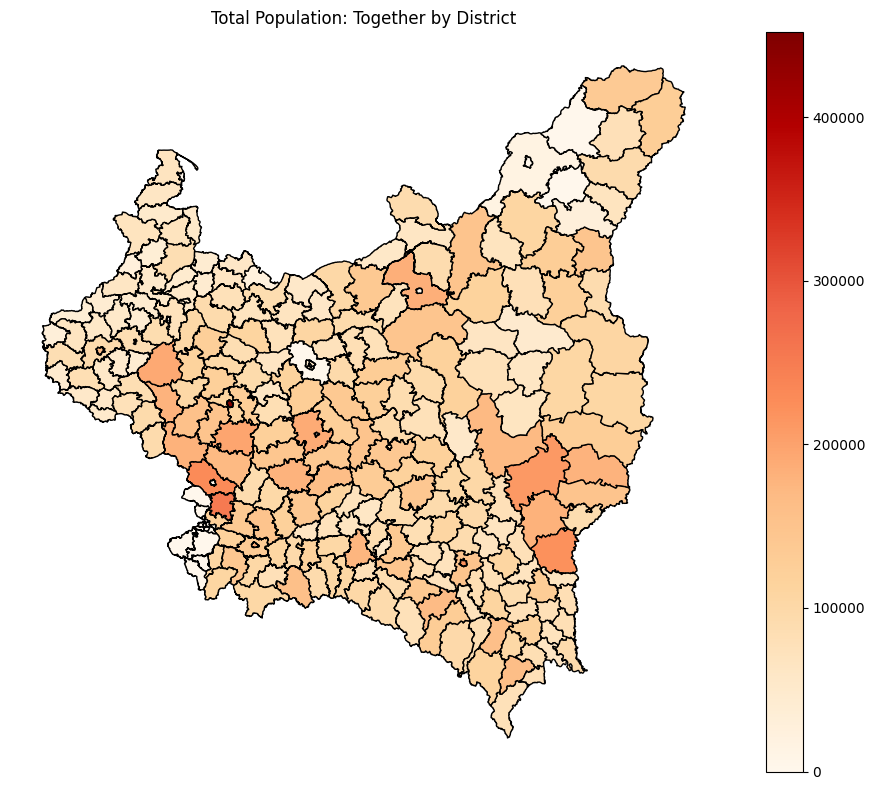

In [15]:
administrative_history.plot_dataset(df = example_df, col_name = 'Total Population: Together', adm_level='District', adm_state_date=example_adm_state_date)

# Agriculture

## Crops

### Prepare prices and yields data for 5 main crops

Load crop prices for 5 main crops:
- 'Pszenica',
- 'Żyto',
- 'Jęczmień',
- 'Owies',
- 'Ziemniaki'.

In cases where prices of multiple crop subtypes are given, I choose:
- 'Ziemniaki: Jadalne', where 'Ziemniaki: Jadalne' and 'Ziemniaki: Fabryczne' are given,
- 'Jęczmień: Browarny', where 'Jęczmień: Browarny', and 'Jęczmień: Innych gatunków' or 'Jęczmień: Na kaszę' are given.

In [ ]:
columns_to_select = ['Pszenica: Together', 'Żyto: Together', 'Jęczmień: Together', 'Jęczmień: Ogółem', 'Owies: Together', 'Ziemniaki: Together', 'Ziemniaki: Jadalne', 'Jęczmień: Browarny']
# Load the crops size
crops_prices_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Crops prices']
crops_prices_dfs = [administrative_history.load_data_table(data_table_id = crops_data_table_id, version = 'harmonized') for crops_data_table_id in crops_prices_data_table_ids]
crops_prices_year_df = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in crops_prices_dfs if extract_date_parts(metadata.date)[1] == '08' or extract_date_parts(metadata.date)[0] is None}
crops_prices_year_df_clean = {}
for year, df in crops_prices_year_df.items():
    existing_columns = [col for col in columns_to_select if col in df.columns]
    df = df[existing_columns]
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    crops_prices_year_df_clean[year] = df

Load crops yields data

In [ ]:
# Load the crops prices
columns_to_select = ['Pszenica: Together', 'Żyto: Together', 'Jęczmień: Together', 'Owies: Together', 'Ziemniaki: Together']
crops_size_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Crops - Size']
crops_size_dfs = [administrative_history.load_data_table(data_table_id = crops_data_table_id, version = 'harmonized') for crops_data_table_id in crops_size_data_table_ids]
crops_size_year_df = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in crops_size_dfs}
crops_size_year_df_clean = {}
for year, df in crops_size_year_df.items():
    existing_columns = [col for col in columns_to_select if col in df.columns]
    df = df[existing_columns]
    df.columns = [col.split(':')[0].strip() for col in df.columns]
    crops_size_year_df_clean[year] = df

I load 5 main crops index computed on the basis of data for all years by Wronski et al. (2025) on the basis of voivodship average prices for 5 main crops.

In [144]:
price_index_5_main_crops = {
    1924: 1.00,
    1925: 1.34,
    1926: 2.12,
    1927: 2.78,
    1928: 3.25,
    1929: 2.06,
    1930: 1.55,
    1931: 1.44,
    1932: 1.24,
    1933: 1.07,
    1934: 1.07,
    1935: 0.84,
    1936: 0.99,
    1937: 1.54,
    1938: 1.14
}

### Compute Crop Value of 5 main crops

In [ ]:
import pandas as pd

crops_production_years = {}

# Find years present in both datasets
common_years = sorted(set(crops_size_year_df_clean.keys()) & set(crops_prices_year_df_clean.keys()))

for year in common_years:
    yield_df = crops_size_year_df_clean[year]
    price_df = crops_prices_year_df_clean[year]

    # Ensure both dfs have the same columns (crops) and index
    if set(yield_df.columns) != set(price_df.columns):
        raise ValueError(f"Crop mismatch in year {year}:\nYield: {yield_df.columns}\nPrice: {price_df.columns}")
    if set(yield_df.index) != set(price_df.index):
        missing_in_price_df_index = set(yield_df.index) - set(price_df.index)
        missing_in_yield_df_index = set(price_df.index) - set(yield_df.index)
        raise ValueError(f"Index mismatch in year {year}:\nMissing in price df: {missing_in_price_df_index}.\nMissing in yield df: {missing_in_yield_df_index}.")

    result_df = yield_df*price_df
    result_df['5 Main Crops Value'] = 

    result_df['5 Main Crops Value %'] = 100*(result_df[['5 Main Crops Value']]/result_df[['5 Main Crops Value']].max())

    crops_production_years[year] = result_df


SyntaxError: invalid syntax (3497596762.py, line 21)

Generate and save plots with 5 Main Crops total production value.

In [ ]:
for year, df in crops_production_years.items():
    plot_path = plots_output_path + f"/5_Crops_Value_{year}.png"
    administrative_history.plot_dataset(df = df, col_name = '5 Main Crops Value %', adm_level='District', adm_state_date=reference_date, save_to_path=plot_path, title = f'5 Main Crops Value (% of max. district value) ({year})', cmap = 'Greens')

### Disaggregate regional crop value added from Wroński et al. (2025)

Load regional data from Wronski et al. (2025)

In [147]:
region_total_crops_production = read_economic_csv_input(adm_level='Region', input_csv_path=region_total_crops_production_path)
region_agro_production_costs_per_ha = read_economic_csv_input(adm_level='Region', input_csv_path=region_agro_production_costs_path)
region_total_sown_area = read_economic_csv_input(adm_level='Region', input_csv_path=region_total_sown_area_path)

Attempting to read: input/harmonization_input/data/regions_total_crops_production_value_ready.csv
Successfully read CSV using encoding: utf-8
Attempting to read: input/harmonization_input/data/regions_production_cost_per_ha_ready.csv
Successfully read CSV using encoding: utf-8
Attempting to read: input/harmonization_input/data/regions_total_sown_area_ha_ready.csv
Successfully read CSV using encoding: utf-8


In [148]:
region_agro_production_costs = region_total_sown_area*region_agro_production_costs_per_ha
region_crops_value_added = region_total_crops_production-region_agro_production_costs

In [149]:
crops_production_years['1928']

,District,5 Main Crops Value,5 Main Crops Value %
0,AUGUSTOWSKI,2.425082e+07,14.335122
1,BIAŁOSTOCKI,3.716331e+07,21.967941
2,BIELSKI (BIELSK PODLASKI),4.543311e+07,26.856379
3,GRODZIEŃSKI,5.452950e+07,32.233429
4,ŁOMŻYŃSKI,8.672511e+07,51.264866
...,...,...,...
259,DZIŚNIEŃSKI,2.380474e+07,14.071436
260,WILEJSKI,2.999645e+07,17.731472
261,WILEŃSKO-TROCKI,6.203823e+07,36.671978
262,POSTAWSKI,2.330363e+07,13.775221


In [150]:
for year, dist_df in crops_production_years.items():
    dist_df.set_index('District', inplace = True)
    dist_va_df = distribute_r_values_to_d(region_df=region_crops_value_added, region_value_col=str(year), dist_df=dist_df, dist_value_col = '5 Main Crops Value', new_col_name='Crops Value Added', d_to_r=d_to_r)
    production_by_year[year]['Crops Value Added'] = dist_va_df['Crops Value Added']

## Livestock

### Load Livestock data

In [151]:
# Load industry_permissions datasets
livestock_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Livestock']
livestock_dfs = [administrative_history.load_data_table(data_table_id = livestock_data_table_id, version = 'harmonized') for livestock_data_table_id in livestock_data_table_ids]
livestock_year_df_dict = {extract_date_parts(metadata.date)[0]: df for df, metadata, date in livestock_dfs}
# Add Livestock_Units column
for year, df in livestock_year_df_dict.items():
    horses = df['Konie: Together']
    cows = df['Bydło rogate: Together']
    pigs = df['Trzoda chlewna: Together'] / 4

    if 'Owce i kozy: Together' in df.columns:
        sheep_goats = df['Owce i kozy: Together'] / 10
        livestock_units = horses + cows + pigs + sheep_goats
    else:
        goats = df.get('Kozy: Together', 0) / 10
        sheep = df.get('Owce: Together', 0) / 10
        livestock_units = horses + cows + pigs + goats + sheep

    df['Livestock_Units'] = livestock_units

Generate and save plots with total livestock units.

In [ ]:
for year, df in livestock_year_df_dict.items():
    print(df.columns)
    plot_path = plots_output_path + f"/Livestock_Units_{year}.png"
    administrative_history.plot_dataset(df = df, col_name = 'Livestock_Units', adm_level='District', adm_state_date=reference_date, save_to_path=plot_path, title = f'Livestock Units ({year})', legend_min = 0, legend_max = 250000, cmap = 'OrRd')

### Compute Livestock Value Added

I use the same method as Wronsky et al. (2025) to disaggregate the total animal production, but on on the region, but on the district level.
I rely on the estimates of a renown Polish agricultural economist Ponikowski who estimated that the animal production in 1928 amounted to 59,07% of the crops production.
I further rely on the estimation of another agricultural economist Dederko who assumed the production value of animals be roughly proportional to the formula:
1 horse = 1 cow = 4 pigs = 10 sheep = 10 goats. I compute the number of 'livestock units' for every district this way.

For year n, I use the total crops production in 1928 deflated by average yearly average crop prices index computed by Wronski et al. (2025). I disaggregate this value by the proportion of the livestock units in district d in year n to the total number of livestock units in year 1928.

In [153]:
# Crop price index in relation to 1928 computed by Wronski et al. (2025).
crop_price_index = {'1924': 0.3059, '1925': 0.4096, '1926': 0.6479, '1927': 0.8540, '1928': 1.0000, '1929': 0.6398, '1930': 0.4818, '1931': 0.4640, '1932': 0.3971, '1933': 0.3377, '1934': 0.3425, '1935': 0.2745, '1936': 0.3244, '1937': 0.5056, '1938': 0.3779}
total_crops_production_1928 = 11205070843
for year, df in livestock_year_df_dict.items():
    livestock_year_df_dict[year].set_index('District', inplace = True)
    
# Interpolate 1928 livestock units
livestock_year_df_dict['1928'] = (livestock_year_df_dict['1927']+livestock_year_df_dict['1929'])/2
livestock_year_df_dict['1926'] = livestock_year_df_dict['1927'] - (livestock_year_df_dict['1928']-livestock_year_df_dict['1927']) # Extrapolate linearly by one year
total_livestock_units_1928 = sum(livestock_year_df_dict['1928']['Livestock_Units'])
for year, df in livestock_year_df_dict.items():
    production_by_year[year]['Livestock Value Added'] = (df['Livestock_Units']/total_livestock_units_1928)*total_crops_production_1928*crop_price_index[year]


In [154]:
production_by_year['1930']

,Crops Value Added,Livestock Value Added
District,,
AUGUSTOWSKI,1.292937e+07,2.446925e+07
BIAŁOSTOCKI,1.992996e+07,3.729420e+07
BIELSKI (BIELSK PODLASKI),2.894273e+07,5.441347e+07
GRODZIEŃSKI,2.982514e+07,3.980160e+07
ŁOMŻYŃSKI,5.216759e+07,3.900325e+07
...,...,...
DZIŚNIEŃSKI,2.648100e+07,3.790801e+07
WILEJSKI,2.566541e+07,3.197312e+07
WILEŃSKO-TROCKI,4.578637e+07,5.101036e+07


year 1924, df.columns: Index(['District'], dtype='object')
year 1925, df.columns: Index(['District'], dtype='object')
year 1926, df.columns: Index(['District', 'Crops Value Added', 'Livestock Value Added'], dtype='object')
year 1927, df.columns: Index(['District', 'Livestock Value Added'], dtype='object')
year 1928, df.columns: Index(['District', 'Crops Value Added', 'Livestock Value Added'], dtype='object')
year 1929, df.columns: Index(['District', 'Livestock Value Added'], dtype='object')
year 1930, df.columns: Index(['District', 'Crops Value Added', 'Livestock Value Added'], dtype='object')
year 1931, df.columns: Index(['District', 'Crops Value Added', 'Livestock Value Added'], dtype='object')
year 1932, df.columns: Index(['District', 'Crops Value Added', 'Livestock Value Added'], dtype='object')
year 1933, df.columns: Index(['District', 'Livestock Value Added'], dtype='object')
year 1934, df.columns: Index(['District', 'Crops Value Added', 'Livestock Value Added'], dtype='object')


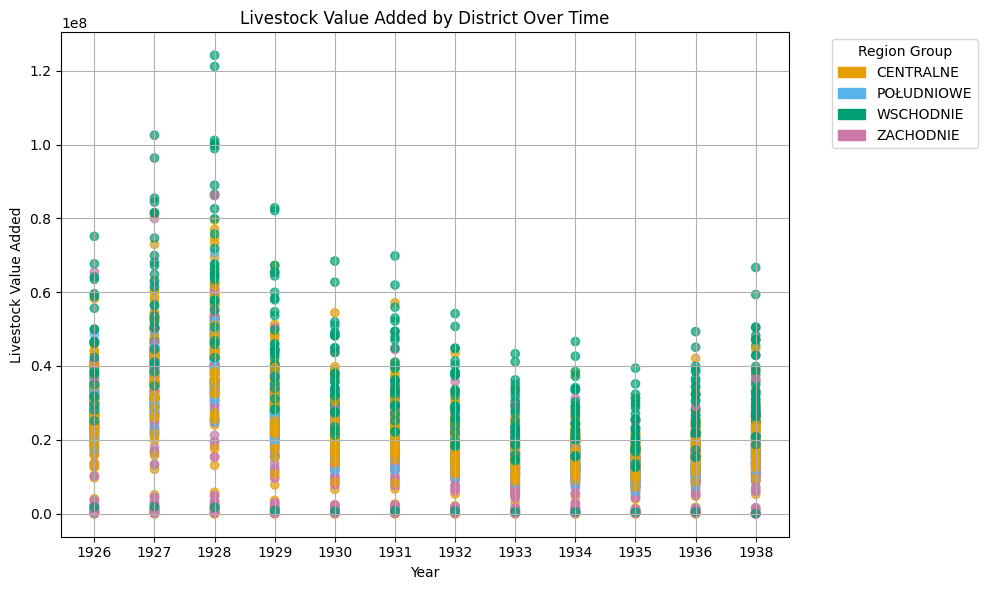

In [155]:
# Reset index
for year, df in production_by_year.items():
    production_by_year[year].reset_index(inplace = True)

plot_values_over_time(
    year_df_dict=production_by_year,
    values_column='Livestock Value Added',
    color_by_district=True,
    d_to_r_group=d_to_r_group,
    r_group_to_color=r_group_to_color
    )

for year, df in production_by_year.items():
    production_by_year[year].set_index('District', inplace = True)

## Forests

### Load forests data

In [187]:
forests_data_table, forests_metadata, forests_date = administrative_history.load_data_table(data_table_id = '1930-forests_area_ha_ready', version = 'harmonized')
forests_data_table.rename(columns={'Area: Together': 'Total Forest Area'}, inplace = True)
dist_area_data_table, dist_area_metadata, dist_area_date = administrative_history.load_data_table(data_table_id = 'dist_area_baseline_adm_state', version = 'harmonized')
dist_area_data_table.rename(columns={'Area: Together': 'Total District Area'}, inplace = True)
forests_data_table = forests_data_table.merge(dist_area_data_table, on='District', how='left')
forests_data_table['Forest as District Area Proportion'] = forests_data_table['Total Forest Area']/forests_data_table['Total District Area']

Generate and save plots with forest area and forest area in comparison to .

In [ ]:
# Plot total forest area:
plot_path = plots_output_path + f"/Total_Forest_Area_{year}.png"
administrative_history.plot_dataset(df = forests_data_table, col_name = 'Total Forest Area', adm_level='District', adm_state_date=example_adm_state_date, save_to_path=plot_path, title = 'Total Forest Area (1930)', cmap = "Greys")

# Plot proportion of forest area to district area:
plot_path = plots_output_path + f"/Proportion_of_Forest_Area_{year}.png"
administrative_history.plot_dataset(df = forests_data_table, col_name = 'Forest as District Area Proportion', adm_level='District', adm_state_date=example_adm_state_date, save_to_path=plot_path, title = 'Forest as District Area Proportion (1930)', cmap = "YlOrBr")

I compute the total value of the forest production as Wronski et al. (2025) - I take yearly incomes of 'Lasy Państwowe' ('State Forests') that controlled and managed 46% of the forests in Poland (Wronski et al., 2025), multiply it by (2.17 = 1/0.46), and spread the incomes according to the forest area per district in 1930. The incomes exist for years 1921-1925 and 1932-1937, for years 1926-1931 they are interpolated with the use of the time series of State Forests' payments to the state budget.

In [188]:
state_forests_incomes = {
    1921: 13_116_000.0,
    1922: 35_291_000.0,
    1923: 33_889_000.0,
    1924: 25_331_000.0,
    1925: 62_522_000.0,
    1926: None,
    1927: None,
    1928: None,
    1929: None,
    1930: None,
    1931: None,
    1932: 120_200_000.0,
    1933: 128_400_000.0,
    1934: 181_300_000.0,
    1935: 210_000_000.0,
    1936: 287_600_000.0,
    1937: 374_100_000.0
    }

prop_total_to_state_forest_area = 2.17

budget_payment = {
    1925: 36_157_000.0,
    1926: 89_287_000.0,
    1927: 118_999_000.0,
    1928: 80_643_000.0,
    1929: 80_395_000.0,
    1930: 72_000_000.0,
    1931: 33_000_000.0,
    1932: 48_000_000.0
}

In [189]:
total_forests_incomes = {year: prop_total_to_state_forest_area*incomes if incomes is not None else None for year, incomes in state_forests_incomes.items()}
print(total_forests_incomes)

{1921: 28461720.0, 1922: 76581470.0, 1923: 73539130.0, 1924: 54968270.0, 1925: 135672740.0, 1926: None, 1927: None, 1928: None, 1929: None, 1930: None, 1931: None, 1932: 260834000.0, 1933: 278628000.0, 1934: 393421000.0, 1935: 455700000.0, 1936: 624092000.0, 1937: 811797000.0}


In [190]:
prop_budget_payment = {}
for year, payment in budget_payment.items():
    prop_budget_payment[year] = payment/budget_payment[1925]
print(prop_budget_payment)

{1925: 1.0, 1926: 2.4694250076057194, 1927: 3.2911745996625825, 1928: 2.230356500815886, 1929: 2.2234975246840167, 1930: 1.9913156511878751, 1931: 0.912686340127776, 1932: 1.3275437674585835}


In [191]:
for year in range(1926, 1932):
    total_forests_incomes[year] = total_forests_incomes[1925]*prop_budget_payment[year]
print(total_forests_incomes)

{1921: 28461720.0, 1922: 76581470.0, 1923: 73539130.0, 1924: 54968270.0, 1925: 135672740.0, 1926: 335033657.0063888, 1927: 446522675.7546256, 1928: 302598577.6425035, 1929: 301668001.5570982, 1930: 270167250.60154325, 1931: 123826656.52570733, 1932: 260834000.0, 1933: 278628000.0, 1934: 393421000.0, 1935: 455700000.0, 1936: 624092000.0, 1937: 811797000.0}


Distribute yearly forest production according to 1930 forest area per district.

In [162]:
for year in range(1924,1938):
    df = forests_data_table[['District', 'Total Forest Area']].copy()
    production_by_year[str(year)]['Forest Value Added'] = df['Total Forest Area']*total_forests_incomes[year]

## Sea Fishing

### Sea Fishing Value Added

The values for sea fishing were provided by GUS from 1931 on. All the values are allocated to the district 'MORSKI'. The values for years 1924-1930 is the value from 1931 extrapolated by Wronski et al. (2025) based on the Pomorskie voivodship value of 5 main crops production in the given year in relation to its value of 5 main crops production in year 1931. Voivosdhip Pomorskie was the only on that had access to the sea.

Inland fishing was added by Ponikowski within his estimations of the Livestock production and it's why I don't add it here.

In [163]:
# Values published by GUS (1931-1938) and extrapolated by Wronski et al. (2025) (1924-1930).
sea_fishing_value = {
    1924: 2_747_607.0,
    1925: 4_081_133.0,
    1926: 5_014_687.0,
    1927: 8_833_781.0,
    1928: 10_921_172.0,
    1929: 7_844_862.0,
    1930: 6_542_626.0,
    1931: 2_393_700.0,
    1932: 2_559_700.0,
    1933: 4_589_400.0,
    1934: 3_991_980.0,
    1935: 3_431_700.0,
    1936: 3_986_000.0,
    1937: 5_127_300.0,
    1938: 7_181_700.0
    }

In [164]:
sea_fishing_df = empty_dist_df.copy()
sea_fishing_df['Sea Fishing'] = 0
for year in range(1924, 1938):
    sea_fishing_year = sea_fishing_df.copy()
    sea_fishing_year.loc['MORSKI', 'Sea Fishing'] = sea_fishing_value[year]
    production_by_year[str(year)]['Sea Fishing Value Added'] = sea_fishing_year['Sea Fishing']

## Horticulture

### Horticulture Value Added

I follow Wronski et al. (2025) and take 6.87% (Ponikowski's estimate for total horticulture production in 1928 in proportion to his estimate of the total crops production in 1928), and assume that horticulture amounts to additional 6.87% of crops production to every district's crops in a given year.

In [167]:
horticulture_df = empty_dist_df.copy()
horticulture_year_df_dict = {}
for year in crops_production_years.keys():
    production_by_year[year]['Horticulture Value Added'] = production_by_year[year]['Crops Value Added']*6.87

## Final agriculture production estimation

In [170]:
for year in crops_production_years.keys():
    print(list(production_by_year[year].columns))

['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']
['Crops Value Added', 'Livestock Value Added', 'Forest Value Added', 'Sea Fishing Value Added', 'Horticulture Value Added']


In [171]:
production_by_year['1926']

,Crops Value Added,Livestock Value Added,Forest Value Added,Sea Fishing Value Added,Horticulture Value Added
District,,,,,
AUGUSTOWSKI,1.141487e+07,2.596613e+07,NaN,0,7.842018e+07
BIAŁOSTOCKI,2.519511e+07,3.738041e+07,NaN,0,1.730904e+08
BIELSKI (BIELSK PODLASKI),2.674572e+07,5.820767e+07,NaN,0,1.837431e+08
GRODZIEŃSKI,3.198928e+07,4.585771e+07,NaN,0,2.197664e+08
ŁOMŻYŃSKI,4.608852e+07,4.307164e+07,NaN,0,3.166281e+08
...,...,...,...,...,...
DZIŚNIEŃSKI,1.895315e+07,4.657632e+07,NaN,0,1.302081e+08
WILEJSKI,3.567628e+07,3.775056e+07,NaN,0,2.450961e+08
WILEŃSKO-TROCKI,5.547694e+07,5.876096e+07,NaN,0,3.811265e+08


In [176]:
# Compute final aggricultural production
for year in crops_production_years.keys():
    production_by_year[year]['Agriculture Value Added'] = production_by_year[year]['Crops Value Added'] + production_by_year[year]['Livestock Value Added'] + production_by_year[year]['Forest Value Added'] + production_by_year[year]['Sea Fishing Value Added'] + production_by_year[year]['Horticulture Value Added']
    production_by_year[year].reset_index(inplace = True)

In [186]:
production_by_year['1926']['Forest Value Added']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
259   NaN
260   NaN
261   NaN
262   NaN
263   NaN
Name: Forest Value Added, Length: 264, dtype: float64

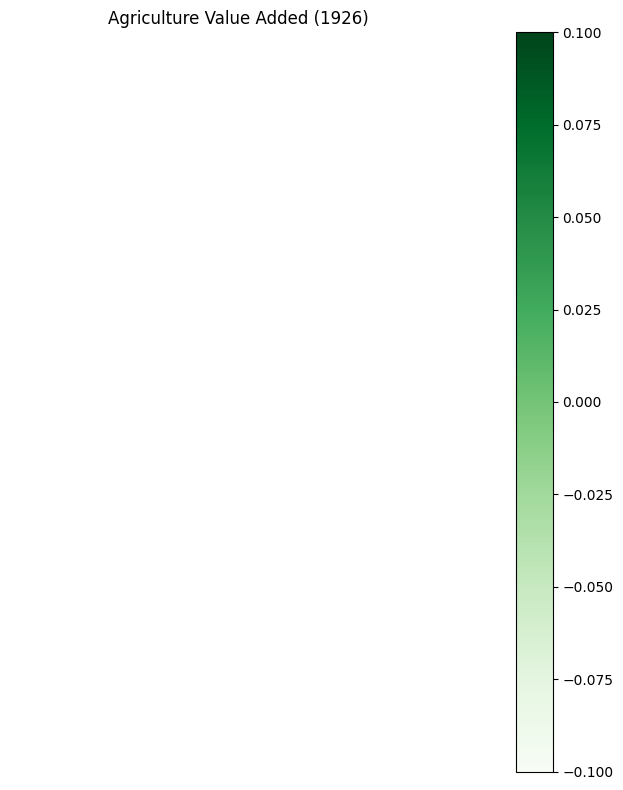

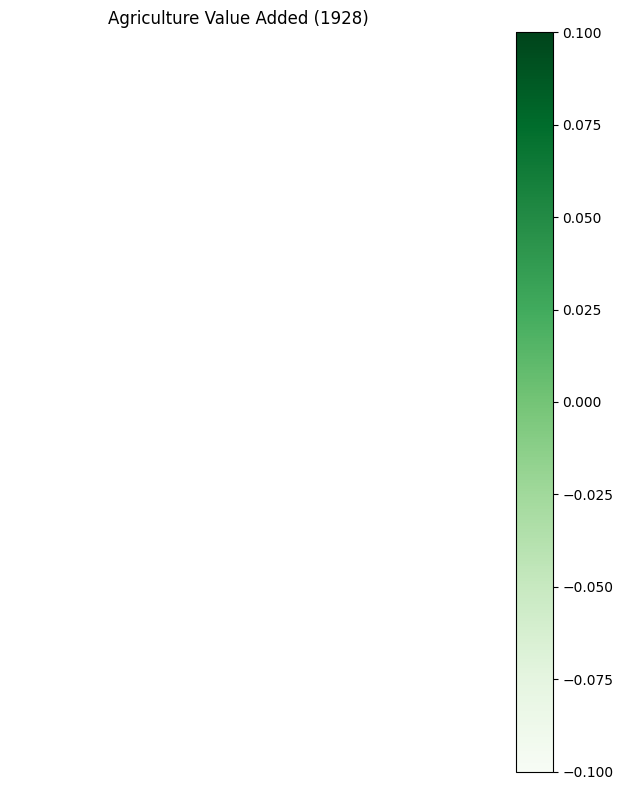

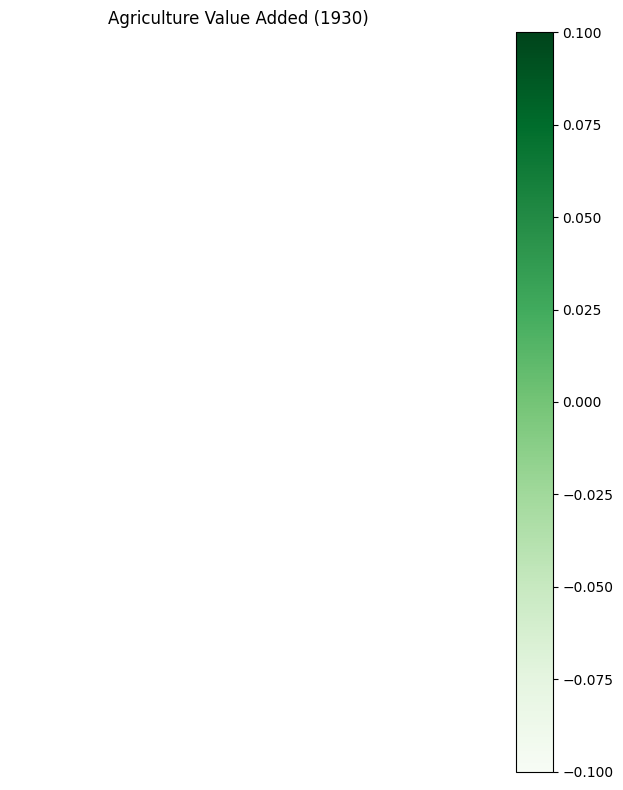

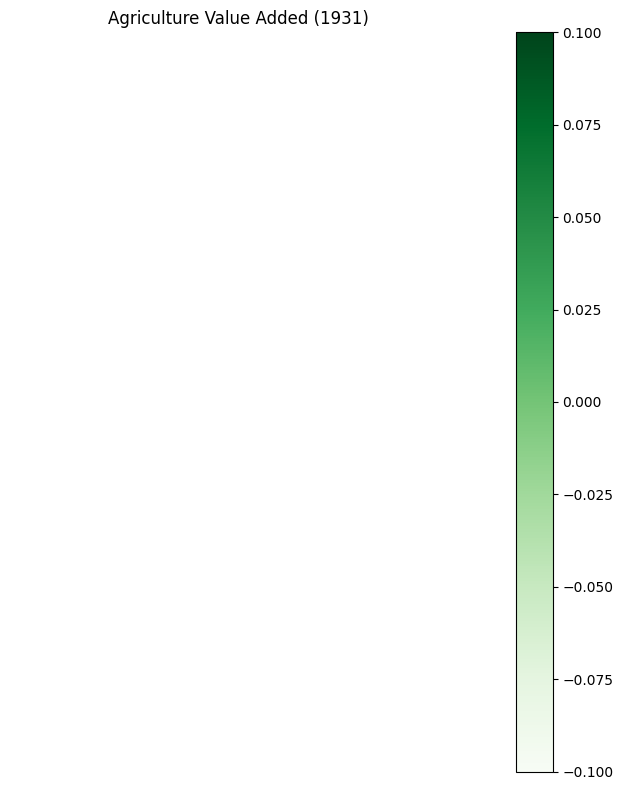

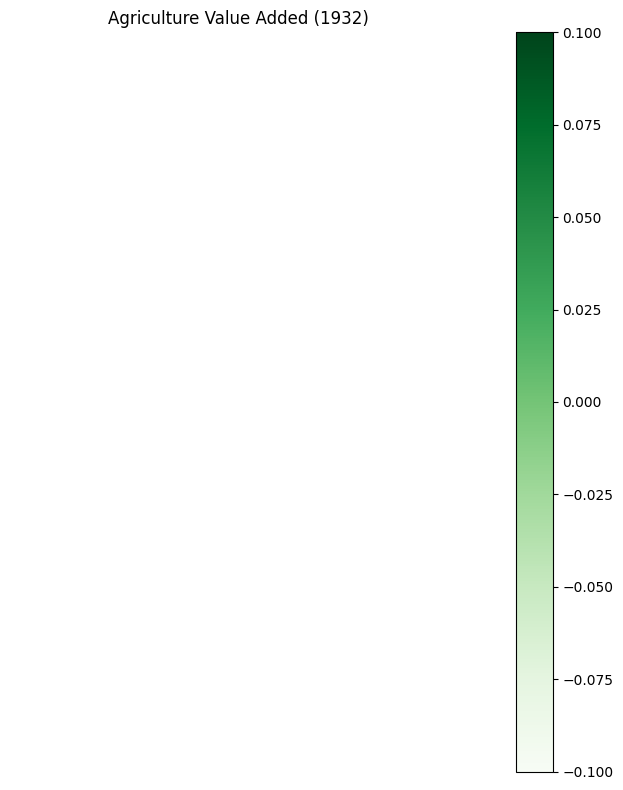

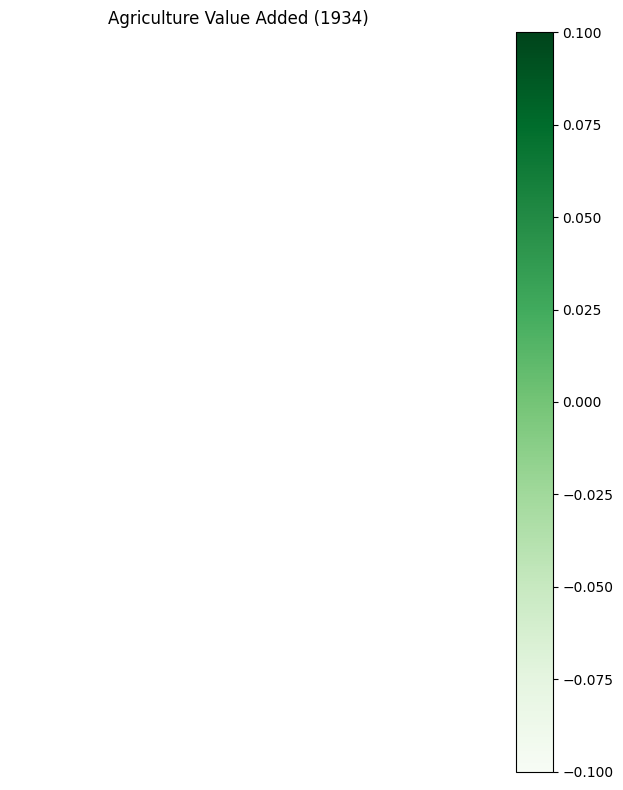

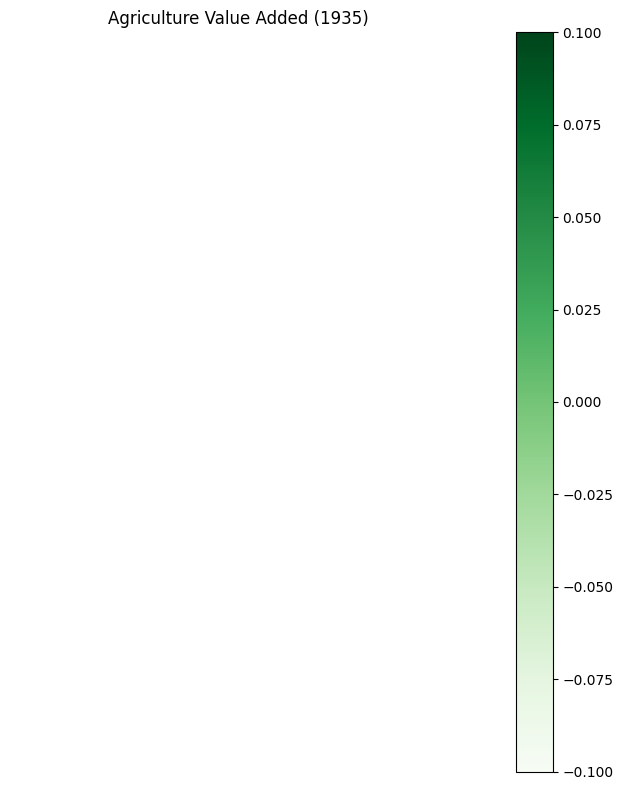

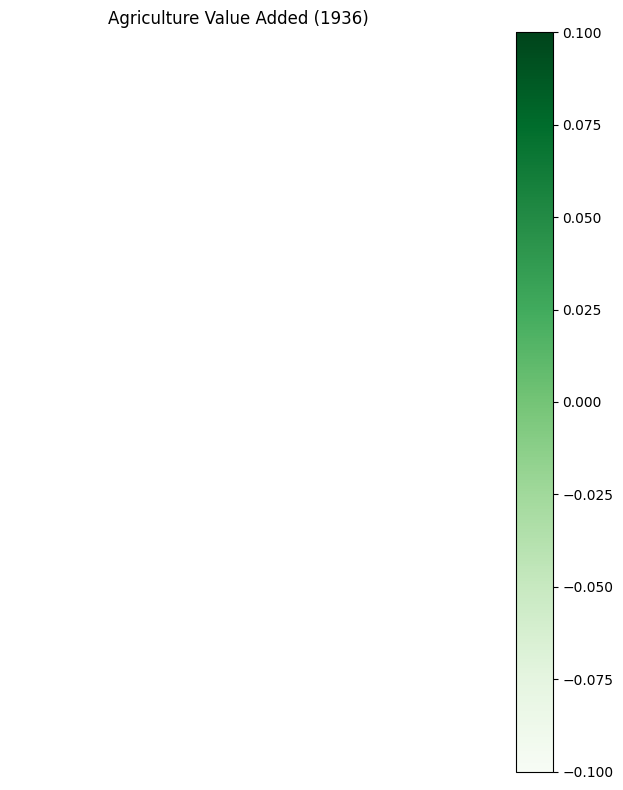

In [182]:
# Plot aggriculture production by district
for year in crops_production_years.keys():
    plot_path = plots_output_path + f"/Agriculture_VA_{year}.png"
    administrative_history.plot_dataset(df = production_by_year[year], col_name = 'Agriculture Value Added', adm_level='District', adm_state_date=reference_date, save_to_path=plot_path, title = f'Agriculture Value Added ({year})', cmap = 'Greens')

# Industry

### Load industry datasets

In [7]:
# Load industry_permissions datasets
industry_permissions_data_table_ids = [data_table.data_table_id for data_table in administrative_history.harmonized_data_metadata if data_table.category=='Industry Permissions']
industry_permissions_dfs = [administrative_history.load_data_table(data_table_id = industry_permissions_data_table_id, version = 'harmonized') for industry_permissions_data_table_id in industry_permissions_data_table_ids]
industry_permissions_year_df_pairs = [(extract_date_parts(metadata.date)[0], df) for df, metadata, date in industry_permissions_dfs]
# Add Livestock_Units column
for year, df in industry_permissions_year_df_pairs:
    print(df.columns)

Index(['District', 'Kategoria IR: Together', 'Kategoria IPR: Together',
       'Kategoria IIR: Together', 'Kategoria IIPR: Together',
       'Kategoria IIIR: Together', 'Kategoria IIIPR: Together',
       'Kategoria IVR: Together', 'Kategoria IVPR: Together',
       'Kategoria VR: Together', 'Kategoria VPR: Together',
       'Kategoria VIR: Together', 'Kategoria VIPR: Together',
       'Kategoria VIIR: Together', 'Kategoria VIIPR: Together',
       'Kategoria VIIIR: Together', 'Kategoria VIIIPR: Together'],
      dtype='object')
Index(['District', 'Kategoria IR: Together', 'Kategoria IPR: Together',
       'Kategoria IIR: Together', 'Kategoria IIPR: Together',
       'Kategoria IIIR: Together', 'Kategoria IIIPR: Together',
       'Kategoria IVR: Together', 'Kategoria IVPR: Together',
       'Kategoria VR: Together', 'Kategoria VPR: Together',
       'Kategoria VIR: Together', 'Kategoria VIPR: Together',
       'Kategoria VIIR: Together', 'Kategoria VIIPR: Together',
       'Kategoria V

In [8]:
industry_permissions_year_df_pairs[-1][1]

,District,1. Number of workers in plants I-VII: Together,2. Plants: total: Together,3. Plants: I-III: Together,4. Plants: IV-V: Together,5. Plants: VI-VII: Together,6. Plants: VIII: Together,7. Mining: I-V: Together,8. Mining: VI-VII: Together,9. Mining: VIII: Together,...,66. Power plants: I-V: Together,67. Power plants: VI-VII: Together,68. Power plants: VIII: Together,69. Services: V-VII: Together,70. Services: VIII: Together,71. Services: hairdressing (within others): Together,72. Services: transport (within others): Together,73. Horticulture and fisheries: V-VII: Together,74. Horticulture and fisheries: VIII: Together,75. Other plants: VIII: Together
0,AUGUSTOWSKI,421.0,398.0,1.0,6.0,18.0,373.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,39.0,18.0,18.0,4.0,5.0,2.0
1,BIAŁOSTOCKI,1818.0,775.0,1.0,17.0,76.0,681.0,0.0,0.0,0.0,...,0.0,2.0,3.0,0.0,35.0,33.0,0.0,1.0,1.0,11.0
2,BIELSKI (BIELSK PODLASKI),2846.0,1381.0,3.0,19.0,103.0,1256.0,0.0,0.0,0.0,...,0.0,4.0,7.0,0.0,63.0,49.0,7.0,0.0,2.0,0.0
3,GRODZIEŃSKI,2806.0,1288.0,0.0,23.0,107.0,1158.0,0.0,0.0,1.0,...,0.0,0.0,5.0,0.0,150.0,86.0,34.0,2.0,11.0,4.0
4,ŁOMŻYŃSKI,504.0,1332.0,0.0,11.0,68.0,1253.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,92.0,49.0,29.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,DZIŚNIEŃSKI,330.0,444.0,0.0,1.0,66.0,377.0,0.0,0.0,0.0,...,0.0,1.0,6.0,0.0,28.0,24.0,0.0,0.0,0.0,1.0
260,WILEJSKI,348.0,380.0,0.0,5.0,51.0,324.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,21.0,14.0,5.0,0.0,0.0,0.0
261,WILEŃSKO-TROCKI,1194.0,510.0,1.0,12.0,83.0,414.0,0.0,0.0,2.0,...,0.0,0.0,4.0,0.0,31.0,27.0,2.0,3.0,8.0,0.0
262,POSTAWSKI,201.0,219.0,0.0,2.0,40.0,177.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,20.0,8.0,10.0,4.0,6.0,0.0


In [9]:
industry_permissions_year_df_pairs[-1][1].columns

Index(['District', '1. Number of workers in plants I-VII: Together',
       '2. Plants: total: Together', '3. Plants: I-III: Together',
       '4. Plants: IV-V: Together', '5. Plants: VI-VII: Together',
       '6. Plants: VIII: Together', '7. Mining: I-V: Together',
       '8. Mining: VI-VII: Together', '9. Mining: VIII: Together',
       '10. Mineral: I-V: Together', '11. Mineral: VI-VII: Together',
       '12. Mineral: VIII: Together',
       '13. Mineral: brickyards (within others): Together',
       '14. Mineral: concrete plants (within others): Together',
       '15. Metal and electrotechnical: I-V: Together',
       '16. Metal and electrotechnical: VI-VII: Together',
       '17. Metal and electrotechnical: VIII: Together',
       '18. Metal and electrotechnical: metal production (within others): Together',
       '19. Metal and electrotechnical: blacksmithing (within others): Together',
       '20. Metal and electrotechnical: locksmithing, repairs (within others): Together',
    

In [ ]:
# Harmonize single csv file
# administrative_history.harmonize_csv_file(
#                     input_csv_path=input_csv_path,
#                     output_csv_path=output_csv_path,
#                     data_table_metadata_dict=data_table_metadata_dict,
#                     date_to=reference_date
#                 )

Harmonizing csv file 'input/harmonization_input/data/1934-crops_q_ready.csv' from 1934-10-07 to 1938-04-01.
Original borders: <AdministrativeState timespan=(1934-07-23, 1937-04-01), regions=19, districts=282>.
Target borders: <AdministrativeState timespan=(1938-04-01, 1938-10-01), regions=19, districts=282>.
Attempting to read: input/harmonization_input/data/1934-crops_q_ready.csv
Ellipsis
Successfully read CSV using encoding: cp1250
⏳ Building conversion matrix from 1934-10-07 to 1938-04-01...
Constructing conversion matrix between two administrative states:
Administrative State from: <AdministrativeState timespan=(1934-07-23, 1937-04-01), regions=19, districts=282>
Administrative State to: <AdministrativeState timespan=(1938-04-01, 1938-10-01), regions=19, districts=282>
Constructing conversion dict between adm. states valid for dates 1934-10-07 and 1938-04-01
Searching districts related by territory to the district AUGUSTOWSKI.
Adding district 'AUGUSTOWSKI' state (1921-02-19, 1939-0

DataTableMetadata(data_table_id='1934-crops_q_ready', category='Crops - Size', source='Statystyka Rolnicza 1934 (Tom IV) (Warszawa 1935)', link='https://statlibr.stat.gov.pl/exlibris/aleph/a22_1/apache_media/XR7QGU6DIR588G31LYPPK1E15QTLP3.pdf', table='11. Powierzchnia zasiewów i zbiory według powiatów. 1934.', page=18, pdf_page=27, description={'pol': 'Zbiory ziemiopłodów.', 'eng': 'Harvest of crops.'}, date='30.08.1934', orig_adm_state_date=datetime.datetime(1934, 10, 7, 0, 0), adm_state_date=datetime.datetime(1938, 4, 1, 0, 0), standardization_comments='', harmonization_method='proportional_to_territory', imputation_method=None, columns={'Jęczmień': ColumnMetadata(unit='quintal', subcategory='Jęczmień', subsubcategory='Together', data_type='float', completeness=0.9128787878787878, n_na=23, n_not_na=241, completeness_after_imputation=None, n_na_after_imputation=None, n_not_na_after_imputation=None), 'Owies': ColumnMetadata(unit='quintal', subcategory='Owies', subsubcategory='Together'